# Fitting a LASSO regression model and  publishing to Azure ML using R

## Summary

Fit a LASSO model to data, then publish the model to AzureML as a web service.

## Description

LASSO, the Least Absolute Shrinkage and Selection Operator, is one of the model complexity control techniques like variable selection and ridge regression. In this notebook you use the `glmnet` package to estimate a LASSO regression model, then publish the model as a web service to Azure ML studio.

## Introduction

### About the method

LASSO, which stands for Least Absolute Shrinkage and Selection Operator, is one of the model complexity control techniques like variable selection and ridge regression. In this notebook we'll demonstrate how to use the *glmnet* package for LASSO regression. For more information about LASSO you can refer to the [LASSO Page][lasso link].

[lasso link]: http://statweb.stanford.edu/~tibs/lasso.html

### Target audience

This notebook is targeted toward data scientists who understand linear regression and want to find out how to fit LASSO regression in R. An operationalization step is also included to show how you can deploy in Azure a web service based on the selected model. 

## Data

In this example, we'll use the housing data from the R package `MASS`. There are 506 rows and 14 columns in the dataset. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found by typing `?Boston` or `help(Boston)` in an R terminal, or at this [UCI page][uci link].

[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

In [1]:
library(MASS) # to use the Boston dataset
?Boston

Boston {MASS},R Documentation


## Analysis

This examples uses `medv`, median home value, as the response variable and the remaining variables as predictors.

The first step in fitting LASSO regression is to determine the value of tuning parameter ÃÂ» (lambda). This parameter controls the overall strength of the penalty. A ÃÂ» value of zero will give exactly the same results as linear regression. The higher the value of ÃÂ», the more the coefficients are "penalised", in other words get moderated to zero.

The `glmnet` package allows you to use cross-validation to choose the value of ÃÂ» that gives the smallest validation error.

In [2]:
# to make results replicable
set.seed(123)

# load libraries
if(!require("glmnet", quietly = TRUE)) install.packages("glmnet")
library(glmnet) # to fit a LASSO model
library(MASS) # to use the Boston dataset

Loaded glmnet 1.9-8



In [3]:
# define response variable and predictor variables
response_column <- which(names(Boston) == "medv")
train_X <- data.matrix(Boston[, -response_column])
train_y <- Boston[,response_column]

# use cv.glmnet with 10-fold cross-validation to pick lambda
model1 <- cv.glmnet(x = train_X, 
                    y = train_y, 
                    alpha = 1, 
                    nfolds = 10, 
                    family = "gaussian", 
                    type.measure = "mse")

In [4]:
summary(model1)

           Length Class  Mode     
lambda     76     -none- numeric  
cvm        76     -none- numeric  
cvsd       76     -none- numeric  
cvup       76     -none- numeric  
cvlo       76     -none- numeric  
nzero      76     -none- numeric  
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  

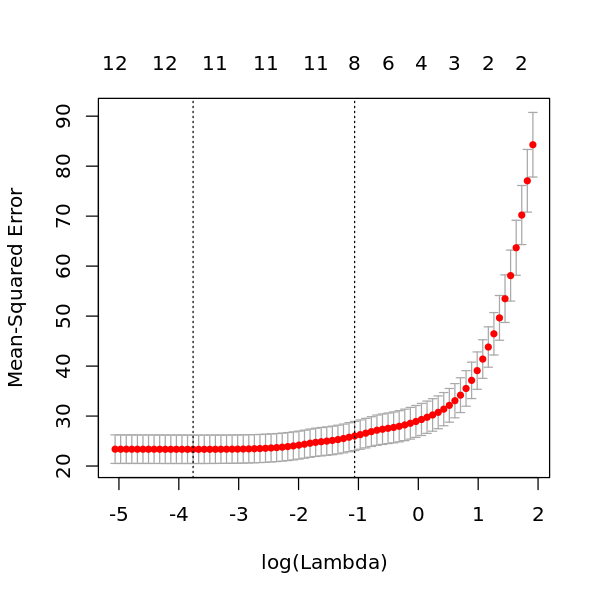

In [5]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(model1)

In the plot above:

* The red dotted line shows the cross-validation error and the error bars show the uppper and lower standard deviation.
* The dotted vertical line to the left is for the optimal ÃÂ» that gives minimum mean cross-validation error.
* The vertical line to the right is for the ÃÂ» where cross-validation error falls within one standard error of the minimum error.
* The number of nonzero coefficients for different ÃÂ» is shown along the axis at the top. The values for ÃÂ» and associated coefficients are printed below.

Lambda that gives minimum mean cross-validated error:

In [6]:
round(model1$lambda.min, 4)

[1] 0.0233

Largest lambda with mean cross-validated error within 1 standard error of the minimum error:

In [7]:
round(model1$lambda.1se, 4)

[1] 0.3453

Coefficients based on lambda that gives minimum mean cross-validated error:

In [8]:
coef(model1, s = "lambda.min")

14 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  34.741082558
crim         -0.099983351
zn            0.042163911
indus         .          
chas          2.691362171
nox         -16.484121381
rm            3.856387745
age           .          
dis          -1.412063666
rad           0.260319556
tax          -0.010144690
ptratio      -0.932724941
black         0.009070332
lstat        -0.522516834

### Varying lambda

While the model selected by cv.glmnet() can be used for making predictions, we also want to better understand how the values of lambda impact the estimated coefficients. Such information can be produced by the glmnet() function. 

In the plot that's generated below, it can be observed that by increasing the value of lambda, the regression parameters are increasingly penalised, and thus move closer to zero.

In the lambda plot below, you can see how the coefficients gradually decrease in value as lambda increaes. This has a particularly high impact on variable 5 (nox, nitrogen oxides concentration (parts per 10 million)).

This shows the value of LASSO regression: the algorithm deals very well with problematic predictors, for example situations where the predictors are higly correlated with one another (multi-collinearity).

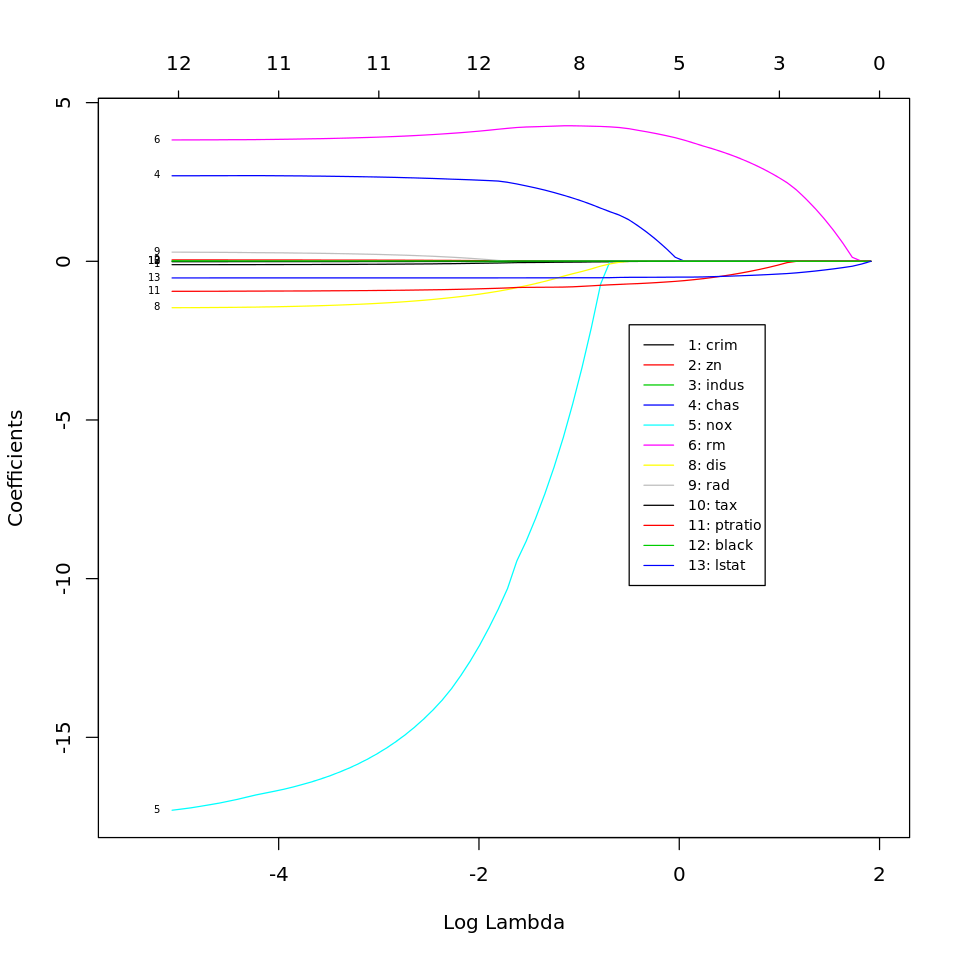

In [9]:
model2 <- glmnet(x = train_X, 
                 y = train_y, 
                 alpha = 1, 
                 family = "gaussian")

# identify variable names
vn = colnames(train_X)
vid <- as.character(seq(1, length(vn)))

# check and exclude the variables with coefficient value 0 
vnat = coef(model2)
vnat_f <- vnat[-1, ncol(vnat)] 
vid <- vid[vnat_f != 0]
vn <- vn[vnat_f != 0]

#define the legend description, line type, and line color
nvars <- length(vn)
legend_desc <- paste(vid, vn, sep=": ")
mylty <- rep(1,nvars)
mycl <- seq(1,nvars)

# plot
options(repr.plot.width = 8, repr.plot.height = 8)
plot(model2, xvar = "lambda", label = TRUE, col = mycl, xlim = c(-5.5, 2))
legend(-0.5, -2, legend_desc, lty = mylty, col = mycl, cex = 0.7) 

The coefficients from this model with the optimal ÃÂ» are also printed below.

As we would expect, they are the same as those from using `cv.glmnet()`.

In [10]:
coef(model2, s = model1$lambda.min)

14 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  34.741082558
crim         -0.099983351
zn            0.042163911
indus         .          
chas          2.691362171
nox         -16.484121381
rm            3.856387745
age           .          
dis          -1.412063666
rad           0.260319556
tax          -0.010144690
ptratio      -0.932724941
black         0.009070332
lstat        -0.522516834

To make predictions, you can use either of the two models:

In [11]:
x_new <- data.matrix(train_X[, -response_column])
pred1 <- predict(model1, newx = x_new, s = "lambda.min")
pred2 <- predict(model2, newx = x_new, s = model1$lambda.min)

head(
    data.frame(
        actual = Boston$medv, 
        model1 = as.vector(pred1), 
        model2 = as.vector(pred2)
    )
)

,actual,model1,model2
1,24,30.19603,30.19603
2,21.6,25.04263,25.04263
3,34.7,30.62206,30.62206
4,33.4,28.74501,28.74501
5,36.2,28.08772,28.08772
6,28.7,25.3641,25.3641


## Web service

### Deploy a web service

With the developed model, you can deploy a web service on Azure so that others can use it to make predictions. You can use the function `publishWebservice()` in the `AzureML` to do this. 

**Important: Publishing and consuming a web service requires you to have valid Azure ML credentials. Concretely, if you logged in using a Guest account, you will get an error. If this is the case, please log in using your Microsoft or Azure account and try again.**

In [12]:
# define predict function
mypredict <- function(newdata){
    if("medv" %in% names(newdata)) {
        w <- match("medv", names(newdata))
        newdata <- newdata[, -w]
        }
  require(glmnet)
  newdata <- data.matrix(newdata) # the prediction data need to be a matrix for glmnet
  predict(model2, newx = newdata, s = model1$lambda.min)
}

# test the prediction function
newdata <- Boston[1:10, ]
mypredict(newdata)

,1
1,30.19603
2,25.04263
3,30.62206
4,28.74501
5,28.08772
6,25.3641
7,23.01697
8,19.57814
9,11.57345
10,19.00047


In [13]:
# load the library
library(AzureML)

# If you use workspace() in a Jupyter notebook, you don't need to specify credentials,
# since the settings are stored for you in a local file.
# If you use this function on your own machine, specify your credentials. See ?workspace.

if(file.exists("~/.azureml/settings.json")){
    ws <- workspace()
} else {
    # workspace_id <- ""
    # authorization_token <- ""
    ws <- workspace(workspace_id, authorization_token)
}

# deploy the service
ep <- publishWebService(ws = ws, fun = mypredict, 
                        name = "LASSOPrediction", 
                        inputSchema = newdata, 
                        outputSchema = list(ans = "numeric"))
# str(ep)

### Consume a web service

With information about the endpoint, you can consume the web service with the following code.

**Important: Publishing and consuming a web service requires you to have valid Azure ML credentials. Concretely, if you logged in using a Guest account, you will get an error. If this is the case, please log in using your Microsoft or Azure account and try again.**

In [14]:
newdata <- Boston
pred <- consume(ep, newdata)$ans
# Note that it can take some time for the published web service to be ready in Azure ML Studio
# The consume() function will retry several times to reach the service

Request failed with status 401. Waiting 5.4 seconds before retry
......Request failed with status 401. Waiting 15.1 seconds before retry
................

In [15]:
predictions <- data.frame(actual = newdata$medv, prediction = pred)
head(predictions)

,actual,prediction
1,24,30.19603
2,21.6,25.04263
3,34.7,30.62206
4,33.4,28.74501
5,36.2,28.08772
6,28.7,25.3641


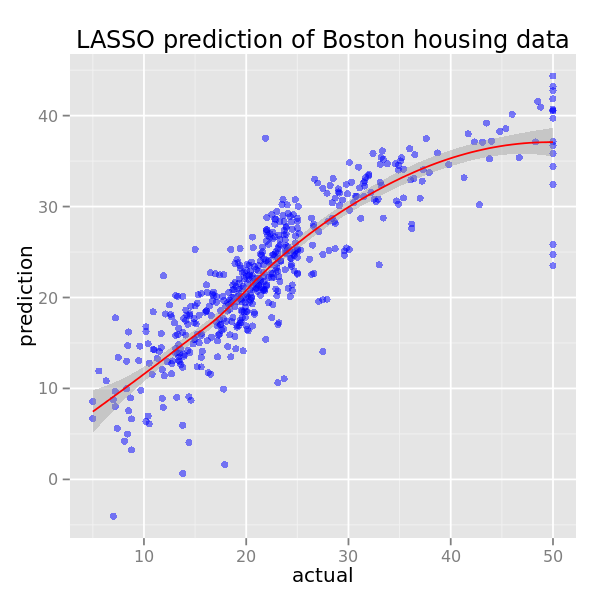

In [16]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(predictions, aes(x = actual, y = prediction)) + 
    geom_point(colour = "blue", alpha = 0.5) +
    stat_smooth(colour = "red") + 
    ggtitle("LASSO prediction of Boston housing data")

The LASSO model estimates the values reasonably well only for some of the observations. All in all, this does not seem like a great model for the supplied data.

## Summary

Using the `Boston` housing data, you fitted a LASSO regression model, by determining the optimal value of the tuning parameter ÃÂ» using cross-validation.

Then you examined the impact of ÃÂ» on the coefficient estimates.

Finally, you published the model as a web service to Azure ML Studio.